# *Credit Card Fraud Detection - Task 1*

![logo](images/logo1.jpg)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

## Compreensão do Tema

### Compreensão do Tema

Uma fraude de cartão de crédito ocorre quando um indivíduo não autorizado acede à informação do cartão de crédito de outra pessoa para fazer compras em seu nome, indevidamente.

Estas fraudes são um problema cada vez mais comum e recorrente na atualidade, pelo que todas as entidades envolvidas investem significativamente em descobrir padrões e indicadores que podem indiciar situações ou tentativas de fraude.

### Determinação dos Objetivos do Tema

De maneira a ir ao encontro das necessidades dos bancos, reguladores e fornecedores de cartões de crédito, é essencial conseguir prever corretamente se uma transação financeira é, com alta probabilidade, fraudulenta.

Como tal, torna-se extremamente útil desenvolver um modelo que identifique eficazmente transações suspeitas de fraude, de maneira a aumentar a segurança financeira e a reduzir as atividades fraudulentas.

### Avaliação da Situação

Os dados disponíveis para análise foram fornecidos por uma empresa de cartões de crédito, correspondendo a informação de 2023, com registos sobre clientes e comerciantes.

O conjunto de dados inclui informação detalhada sobre transações, clientes, comerciantes e cidades, estando cada transação detalhada como legítima ou fraudulenta, permitindo uma abordagem de aprendizagem supervisionada para identificar padrões indicadores de fraude.

### Determinação dos Objetivos de Mineração de Dados

O problema consiste em prever se uma transação é, ou não, fraudulenta, tendo como base um conjunto de dados associados à transação, ou seja, classificar cada transação como pertencente a um de dois grupos, mutuamente exclusivos: fraudulenta ou legítima (não fraudulenta).

Para resolver o problema, deve ser desenvolvido um modelo de aprendizagem computacional supervisionada com capacidade para efetuar uma classificação binária que distinga os dois casos possíveis para cada transação.

Pretende-se que o modelo, devidamente treinado seguindo uma abordagem de aprendizagem supervisionada, tenha uma exatidão de TODO% a classificar os dados de teste, considerando-se, nesse caso, garantida a sua viabilidade prática.

Tendo em conta que é mais importante capturar todas as transações fraudulentas, ainda que correndo o risco de incluir algumas transações legítimas, do que só identificar as transações garantidamente fraudulentas, mas deixando escapar algumas transações fraudulentas, espera-se que o modelo tenha um *recall* mais elevado do que a sua precisão, ainda que ambas as medidas de desempenho devam retornar valores elevados. TODO - nesta secção?

## Compreensão dos Dados

### Recolha dos Dados Iniciais

O *dataset* fornecido é constituído por quatro ficheiros, dividindo a informação da forma abaixo exposta.

1. **cities.csv:** informação sobre várias cidades
2. **customers.csv:** informação demográfica de cada cliente
3. **merchants.csv:** detalhes de cada comerciante
4. **transactions.csv:** registos de transações individuais

In [ ]:
cities = pd.read_csv("data/cities.csv")
customers = pd.read_csv("data/customers.csv")
merchants = pd.read_csv("data/merchants.csv")
transactions = pd.read_csv("data/transactions.csv")

O ficheiro **cities.csv**, que contém informação sobre várias cidades, é constituído por 5 linhas e 5 colunas.

In [ ]:
cities.info()

Cada linha representa uma cidade e as colunas são as seguintes:

0. **city:** nome da cidade
1. **lat:** latitude da cidade
2. **lon:** longitude da cidade
3. **city_pop:** população da cidade
4. **state:** estado a que pertence a cidade

In [ ]:
cities.head()

O ficheiro **customers.csv**, que contém a informação demográfica de cada cliente, é constituído por 1100 linhas e 9 colunas.

In [ ]:
customers.info()

Cada linha representa um cliente e as colunas são as seguintes:

0. **cc_num:** número do cartão de crédito do cliente
1. **first:** primeiro nome do cliente
2. **last:** último nome do cliente
3. **gender:** género do cliente
4. **street:** rua da morada do cliente
5. **city:** cidade da morada do cliente
6. **zip:** código-postal da morada do cliente
7. **job:** emprego do cliente
8. **dob:** data de nascimento do cliente

In [ ]:
customers.head()

O ficheiro **merchants.csv**, que contém os detalhes de cada comerciante, é constituído por 100 linhas e 5 colunas.

In [ ]:
merchants.info()

Cada linha representa um comerciante e as colunas são as seguintes:

0. **merchant:** nome do comerciante
1. **category:** categoria do negócio do comerciante
2. **merch_lat:** latitude do comerciante
3. **merch_lon:** longitude do comerciante
4. **merchant_id:** identificador único do comerciante

In [ ]:
merchants.head()

O ficheiro **transactions.csv**, que contém os registos de transações individuais, é constituído por 30000 linhas e 9 colunas.

In [ ]:
transactions.info()

Cada linha representa uma transação e as colunas são as seguintes:

0. **index:** índice da transação
1. **trans_date_trans_time:** data e hora da transação
2. **cc_num:** número do cartão de crédito associado à transação
3. **device_os:** sistema operativo a partir do qual foi efetuada a transação
4. **merchant:** nome do comerciante da transação
5. **amt:** quantidade da transação
6. **trans_num:** número único da transação
7. **unix_time:** *timestamp* *Unix* da transação
8. **is_fraud:** etiqueta que indica se a transação foi fraudulenta (1) ou não (0)

In [ ]:
transactions.head()

Os atributos *trans_data_trans_time*/*unix_time*, *merchant* e *amt* parecem ser aqueles mais relevantes para determinar o valor da variável-alvo (*is_fraud*), por serem os que mais se relacionam com a transação propriamente dita.

Em sentido contrário, as colunas *index*, *trans_num*, *merchant_id*, *first* e *last* deverão ser completamente irrelevantes para o modelo, por serem meramente indicativas. Por isso, estas colunas poderão vir a ser eliminadas numa próxima fase.

Tendo em conta que existe um número bastante elevado de dados (30000 transações, que serão divididos em conjuntos de treino e de teste) e de informação adicional (sobre cidades, clientes e comerciantes), é expectável que se consigam extrair conclusões pertinentes a partir dos dados, isto é, fazer previsões/classificações acertadas, pelo que não se afigura necessário procurar novos dados.

Para além disto, o número de atributos considera-se mais do que suficiente para o problema a tratar, pelo que a dimensionalidade poderá ter de ser reduzida de maneira a evitar a "maldição da dimensionalidade".

Sendo os dados provenientes de uma só origem, não se antecipam quaisquer problemas de compatibilidade/coerência.

Por último, os casos de valores em falta e/ou incorretos serão analisados individualmente: se possível, os valores serão corrigidos ou imputados; senão, as linhas serão eliminadas, visto que o número total de dados é suficiente para a criação de um modelo robusto.

### Descrição dos Dados

A quantidade de dados disponíveis (30000 transações com a respetiva informação) parece adequada para o modelo pretendido, permitindo o desenvolvimento de um modelo simultaneamente eficaz (em termos de exatidão) e eficiente (em termos de tempo de processamento computacional).

A eliminação de colunas/atributos irrelevantes deverá ser suficiente para escapar à maldição da dimensionalidade e evitar *overfitting*, bem como melhorar o desempenho do programa.

Os tipos dos valores e as respetivas escalas apresentam-se abaixo.

**Cidades:** 5 linhas e 5 colunas

| Atributo | Tipo | Escala | Formato |
| -------- | ---- | ------ | ------- |
| **city** | categórico | nominal | *string* |
| **lat** | numérico contínuo | rácio | número decimal |
| **long** | numérico contínuo | rácio | número decimal |
| **city_pop** | numérico discreto | rácio | número inteiro |
| **state** | categórico | nominal | *string* |

Portanto, todos os dados de cidades estão representados/codificados de forma adequada.

In [54]:
cities.dtypes

city         object
lat         float64
long        float64
city_pop      int64
state        object
dtype: object

**Clientes:** 1100 linhas e 9 colunas

| Atributo | Tipo | Escala | Formato |
| -------- | ---- | ------ | ------- |
| **cc_num** | categórico | nominal | número inteiro |
| **first** | categórico | nominal | *string* |
| **last** | categórico | nominal | *string* |
| **gender** | categórico | nominal | *string* |
| **street** | categórico | nominal | *string* |
| **city** | categórico | nominal | *string* |
| **zip** | categórico | nominal | número decimal |
| **job** | categórico | nominal | *string* |
| **dob** | categórico | ordinal | *string* |

Neste caso, os atributos *cc_num* e *zip* são valores categóricos com escala nominal - por não representarem quantidades e não haver uma ordem entre eles -, mas estão representados como números (inteiros e decimais, respetivamente), pelo que não se encontram codificados da forma mais apropriada.

Como tal, de maneira a evitar más interpretações por parte do modelo, os formatos de representação das colunas *cc_num* e *zip* terão de ser convertidos para *string* ou `pandas.Categorical`, para garantir que são tratados como valores categóricos nominais.

In [53]:
customers.dtypes

cc_num      int64
first      object
last       object
gender     object
street     object
city       object
zip       float64
job        object
dob        object
dtype: object

**Comerciantes:** 100 linhas e 5 colunas

| Atributo | Tipo | Escala | Formato |
| -------- | ---- | ------ | ------- |
| **merchant** | categórico | nominal | *string* |
| **category** | categórico | nominal | *string* |
| **merch_lat** | numérico contínuo | rácio | número decimal |
| **merch_long** | numérico contínuo | rácio | número decimal |
| **merchant_id** | categórico | nominal | número inteiro |

Aqui, todos os atributos estão representados adequadamente, com exceção de *merchant_id*, que está codificado como um número inteiro, mas é um valor categórico nominal, dado que, apesar de ser representado por um número, corresponde a um identificador que não traduz nenhuma relação de ordem significativa.

Deste modo, o formato da coluna *merchant_id* terá de, posteriormente, ser transformado em *string* ou `pandas.Categorical`, caso se pretenda a sua ingestão por parte do modelo.

In [52]:
merchants.dtypes

merchant        object
category        object
merch_lat      float64
merch_long     float64
merchant_id      int64
dtype: object

**Transações:** 30000 linhas e 9 colunas

| Atributo | Tipo | Escala | Formato |
| -------- | ---- | ------ | ------- |
| **index** | categórico | nominal | número inteiro |
| **trans_date_trans_time** | categórico | ordinal | *string* |
| **cc_num** | categórico | nominal | número inteiro | 
| **device_os** | categórico | nominal | *string* |
| **merchant** | categórico | nominal | *string* |
| **amt** | numérico contínuo | rácio | número decimal |
| **trans_num** | categórico | nominal | *string* |
| **unix_time** | numérico discreto | intervalar | número inteiro |
| **is_fraud** | categórico | nominal | número inteiro |

Neste conjunto de transações, as colunas *index*, *cc_num* e *is_fraud* deveriam ter um formato mais adequado ao seu significado.

Ou seja, tal como anteriormente, estas colunas são do tipo categórico com escala nominal porque, embora os seus valores sejam números inteiros, a ordem entre eles é arbitrária, pelo que, numa fase mais avançada do processo de desenvolvimento, os formatos terão de ser convertidos para *string* ou `pandas.Categorical` garantir um tratamento adequado por parte do modelo.

Note-se ainda que a coluna *trans_date_trans_time* é a única com formato *string* que representa valores categóricos ordinais (em vez de nominais), o que poderia levar à necessidade de alguma atenção redobrada num momento posterior, mas, na verdade, esta coluna deverá ser removida por traduzir a mesma informação que a coluna *unix_time* que, por sua vez, tem uma representação mais adequada.

In [55]:
transactions.dtypes

index                      int64
trans_date_trans_time     object
cc_num                     int64
device_os                 object
merchant                  object
amt                      float64
trans_num                 object
unix_time                  int64
is_fraud                   int64
dtype: object

Em todo o *dataset*, a única coluna que se pode considerar codificada é *is_fraud*, sendo que o esquema de codificação consiste em representar "verdadeiro"/"sim" como 1 e "falso"/"não" como 0. Nenhuma das restantes colunas está codificada.

In [ ]:
cities.describe(include = 'all')

In [ ]:
customers.describe(include = 'all')

In [ ]:
merchants.describe(include = 'all')

In [ ]:
transactions.describe(include = 'all')

Ao realizar uma análise estatística descritiva sobre os dados, observando a contagem, a unicidade, a frequência, a média, o desvio padrão, os extremos (mínimo e máximo) e os quartis (incluindo a mediana) dos valores presentes em cada coluna, constatam-se os seguintes factos:

- Existem apenas 5 cidades distintas, todas nos Estados Unidos da América;
- A proporção de clientes homens/mulheres é razoavelmente equilibrada (41%/59%);
- Como existem 6 cidades presentes no conjunto de clientes, pelo menos uma delas não estará mapeada no conjunto de cidades (por serem 5), pelo que não terá informações/detalhes adicionais;
- Existem apenas 7 profissões distintas de clientes;
- Existem apenas 5 categorias distintas de comerciantes;
- O espaço geográfico no qual se encontram os comerciantes é muito mais abrangente do que o espaço geográfico das cidades, isto é, haverá muitos comerciantes que - pelas suas coordenadas (latitude e longitude) - não se situam nos Estados Unidos da América;
- Existem 2 transações efetuadas exatamente ao mesmo tempo (com ano, dia, hora, minuto e segundo coincidentes), que poderão ser a mesma;
- Como existem 101 comerciantes presentes no conjunto de transações, pelo menos um deles não estará mapeado no conjunto de comerciantes (por serem 100), pelo que não terá informações/detalhes adicionais;
- Existem várias transações com o mesmo número (*trans_num*), que deverão ser duplicadas;
- No conjunto de dados considerado, apenas 2% das transações são fraudulentas.

Assim, é possível concluir que:

- O conjunto de dados é desequilibrado, visto que a variável-alvo (*is_fraud*) não divide as transações em dois grupos com aproximadamente o mesmo tamanho, mas sim num grupo com cerca de 600 transações (fraudulentas) e noutro com cerca de 294000 transações (legítimas), ou seja, quase 50 vezes maior;
- Para além das hipóteses levantadas anteriormente, talvez exista alguma relação entre a legitimidade de uma transação e a localização geográfica do comerciante, isto é, uma transação poderá ser fraudulenta com maior probabilidade se o comerciante se situar fora dos Estados Unidos da América.

### Exploração dos Dados

Nesta fase, desenham-se os gráficos para os atributos considerados relevantes, tendo em vista a extração de novas conclusões.

Para o conjunto de cidades, não é necessário nenhum gráfico para analisar melhor os seus dados, visto que apenas contém cinco entradas.

In [56]:
cities

,city,lat,long,city_pop,state
0,Los Angeles,34.0522,-118.2437,3979576,CA
1,Houston,29.7604,-95.3698,2328000,TX
2,Phoenix,33.4484,-112.0740,1680992,AZ
3,Chicago,41.8781,-87.6298,2716000,IL
4,New York,40.7128,-74.0060,8419600,NY


Para o conjunto de clientes, pode visualizar-se a sua distribuição por género, por cidade, por profissão e por idade (derivada a partir da data de nascimento).

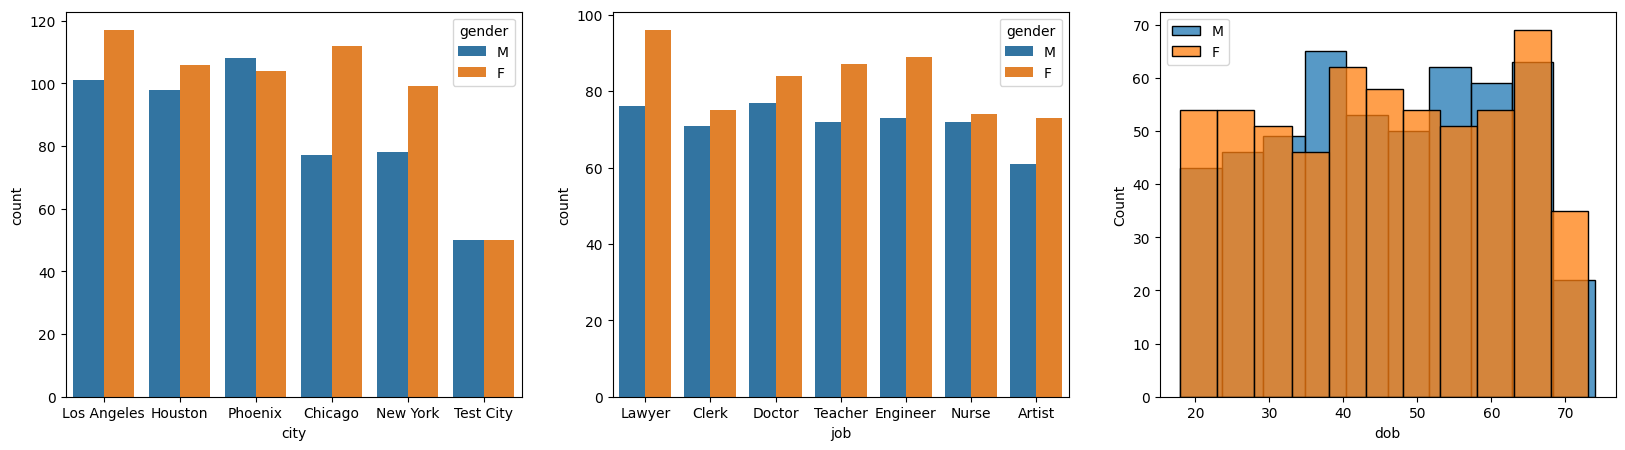

In [79]:
plt.figure(figsize = (20, 5))

plt.subplot(1, 3, 1)
sb.countplot(data = customers, x = 'city', hue = 'gender')

plt.subplot(1, 3, 2)
sb.countplot(data = customers, x = 'job', hue = 'gender')

plt.subplot(1, 3, 3)
sb.histplot(data = (pd.to_datetime('today') - pd.to_datetime(customers[customers['gender'] == 'M']['dob'])).dt.days // 365, label = 'M')
sb.histplot(data = (pd.to_datetime('today') - pd.to_datetime(customers[customers['gender'] == 'F']['dob'])).dt.days // 365, label = 'F')
plt.legend(plt.gca().get_legend_handles_labels()[1])

In [ ]:
plt.figure(figsize = (20, 15))

not_fraud = transactions[transactions['is_fraud'] == 0].drop(['index', 'trans_date_trans_time', 'trans_num', 'is_fraud'], axis = 1)
fraud = transactions[transactions['is_fraud'] == 1].drop(['index', 'trans_date_trans_time', 'trans_num', 'is_fraud'], axis = 1)

for i, col in enumerate(not_fraud.columns):
    plt.subplot(4, 3, i + 1)
    sb.histplot(data = not_fraud[col], label = 'Not Fraud')
    sb.histplot(data = fraud[col], label = 'Fraud')
    plt.legend(plt.gca().get_legend_handles_labels()[1])


In [ ]:
columns = transactions.columns.drop(['index', 'trans_date_trans_time', 'trans_num'])
continuous = [col for col in columns if (transactions[col].nunique() > 11 or col == 'is_fraud')]

plt.figure(figsize = (15, 15))
sb.pairplot(transactions[continuous], hue='is_fraud')

In [ ]:
non_binary = [col for col in columns if transactions[col].nunique() > 2 and transactions[col].nunique() <= 11]

plt.figure(figsize = (20, 5))
for (i, column) in enumerate(non_binary):
    plt.subplot(1, 3, i + 1)
    table = pd.crosstab(transactions[column], transactions['is_fraud'])
    row_sum = table.sum(axis = 1)
    percentages = (table.T / row_sum * 100).T
    annotations = [['{} ({}%)'.format(count, round(percentage)) for percentage, count in zip(row, table_row)] for table_row, row in zip(table.values, percentages.values)]
    sb.heatmap(table, annot = annotations, fmt = '', cmap = 'coolwarm', linewidths=.5)

In [ ]:
binary = [col for col in columns if transactions[col].nunique() == 2 and col != 'is_fraud']

plt.figure(figsize = (20, 5))
for (i, column) in enumerate(binary):
    plt.subplot(1, 3, i + 1)
    table = pd.crosstab(transactions[column], transactions['is_fraud'])
    row_sum = table.sum(axis = 1)
    percentages = (table.T / row_sum * 100).T
    annotations = [['{} ({}%)'.format(count, round(percentage)) for percentage, count in zip(row, table_row)] for table_row, row in zip(table.values, percentages.values)]
    sb.heatmap(table, annot = annotations, fmt = '', cmap = 'coolwarm', linewidths=.5)

In [ ]:
plt.figure(figsize = (10, 10))

correlation = transactions.drop(['index', 'trans_date_trans_time', 'device_os', 'merchant', 'trans_num'], axis = 1).corr()
sb.heatmap(correlation, annot = True, cmap='coolwarm', vmin = -1, vmax = 1)

### Verificação da Qualidade dos Dados

## Preparação dos Dados

In [ ]:
data = transactions.merge(merchants, on = 'merchant', how = 'outer').merge(customers.merge(cities, on = 'city', how = 'outer'), on = 'cc_num', how = 'outer')

data.head()
data.describe(include = 'all')

## Análise Descritiva